In [169]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import glob
import os.path
from numpy import genfromtxt
import skimage.transform as transform

## Functions

In [40]:
def imhist(im):
  # calculates normalized histogram of an image
    m, n = im.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[im[i, j]]+=1
    return np.array(h)/(m*n)

def cumsum(h):
    # finds cumulative sum of a numpy array, list
    return [sum(h[:i+1]) for i in range(len(h))]

def histeq(im):
    #calculate Histogram
    h = imhist(im)
    cdf = np.array(cumsum(h)) #cumulative distribution function
    sk = np.uint8(255 * cdf) #finding transfer function values
    s1, s2 = im.shape
    Y = np.zeros_like(im)
    # applying transfered values for each pixels
    for i in range(0, s1):
        for j in range(0, s2):
            Y[i, j] = sk[im[i, j]]
    H = imhist(Y)
    #return transformed image, original and new istogram, 
    # and transform function
    return Y , h, H, sk

In [149]:
def detectobj(img, blur_radius, threshold):
    imgf = ndimage.gaussian_filter(img, blur_radius)
    labeled, nr_objects = ndimage.label(imgf > threshold)
    if nr_objects == 0:
        return None, [], []
    center = img.shape[0] // 2
    cid = labeled[center, center]
    if len(np.where(labeled == cid)[0]) >= labeled.shape[0]**2 / 2:
        # the center of galaxy cannot belong to an object which spans more than 50% of pixels.
        return None, [], []
    
    tmp = labeled == cid
    x = np.where(tmp.any(axis=0))[0]
    y = np.where(tmp.any(axis=1))[0]
    bound = np.abs(np.array([x[0], x[-1], y[0], y[-1]]) - center).max()
    lower = center - bound
    upper = center + bound
    xs = [lower, lower, upper, upper, lower]
    ys = [lower, upper, upper, lower, lower]
    return labeled, xs, ys

# Working with sample data

In [2]:
datadir = "Sample_Data/SAMPLE/"
ssdsids = list(set([os.path.split(s)[1].split('-')[0] for s in glob.glob(datadir+"*.csv")]))

## Finding a bounding box on a single image

In [35]:
idx = 2
g_img = genfromtxt(datadir + ssdsids[idx] + '-g.csv', delimiter=',')
i_img = genfromtxt(datadir + ssdsids[idx] + '-i.csv', delimiter=',')

In [36]:
log_g_img = np.log10(g_img - g_img.min() + 1e-16)

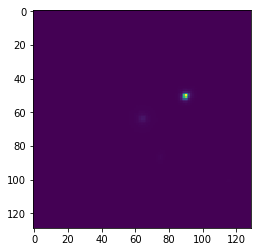

In [37]:
plt.imshow(g_img)

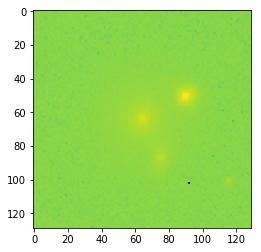

In [38]:
# add a very small positive value (1e-16) to bring every value positive.
plt.imshow(log_g_img)

We found this algorithm sometimes failed if the range between minimum and maximum values after histogram equalization is small.

On the other hand, log transformed image seems to work beter.

27 255


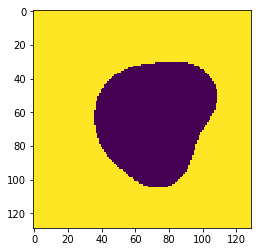

([20, 20, 108, 108, 20], [20, 108, 108, 20, 20])

In [109]:
# g_img2 = np.uint8((g_img - g_img.min()) / (g_img.max() - g_img.min()) * 255.0)
g_img2 = np.uint8(log_g_img)
y, _, _, _ = histeq(g_img2)
print(y.min(), y.max())
xs, ys = detectobj(y, 10, y.mean())
xs, ys

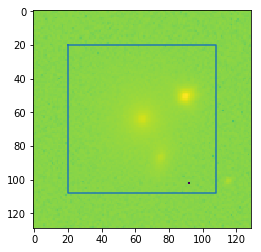

In [110]:
implot = plt.imshow(log_g_img)
plt.plot(xs, ys, '-')
plt.show()

# Finding out bounding box for identifying the best image size for deep learning

In [162]:
sizes = []
cropped = []
failed = 0
for idx in ssdsids[0:10]:
    g_img = genfromtxt(datadir + idx + '-g.csv', delimiter=',')
    log_g_img = np.log10(g_img - g_img.min() + 1e-16)
    imgsize = g_img.shape[0]
    g_img2 = np.uint8(log_g_img)
    y, _, _, _ = histeq(g_img2)
    objs, xs, ys = detectobj(y, 10, (y.max() - y.min())/2)
    if len(xs) != 0 and ys[1] - ys[0] < imgsize:
        sizes.append(ys[1] - ys[0])
        height = sizes[-1]
        cropped.append(g_img[xs[0]:xs[0]+height,xs[0]:xs[0]+height])
#         implot = plt.imshow(objs)
#         plt.plot(xs, ys, '-')
#         plt.title(idx)
#         plt.show()
    else:
        failed += 1

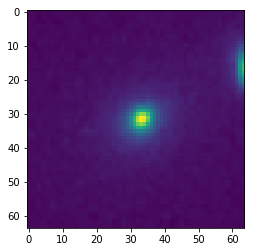

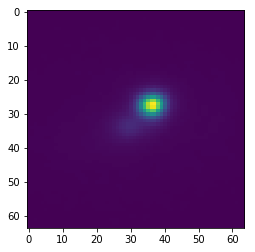

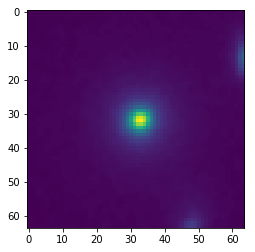

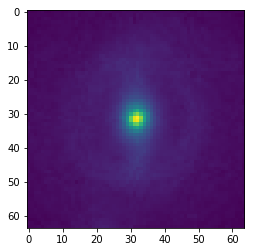

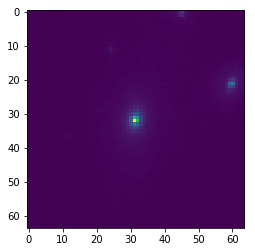

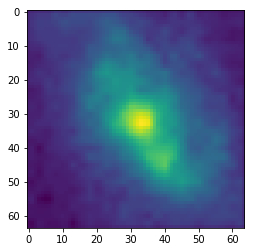

In [172]:
for c in cropped:
    plt.imshow(transform.resize(c, (64, 64)))
    plt.show()